

=============================================================================
PRACTICAL TASK 2: GENERATIVE VS DISCRIMINATIVE CLASSIFIERS
=============================================================================

Comparing Naïve Bayes Classifier and Logistic Regression

Reference Paper:
"On Discriminative vs. Generative classifiers: A comparison of logistic 
regression and naive Bayes" - Ng & Jordan (NIPS 2001)

Student: Daria Stetsenko, daria.stetsenko@uzh.ch, 23-740-806 / Zahraa Zaiour,  zahraa.zaiour@uzh.ch, 24-750-093


=============================================================================
TASK OBJECTIVES:
=============================================================================
1. Implement Naïve Bayes Classifier from scratch (binary, Gaussian, categorical)
2. Compare NBC with Logistic Regression on multiple datasets
3. Reproduce learning curve experiments from the paper

Datasets:
- binary_test.csv (binary features)
- voting.csv (binary features after encoding)
- breast-cancer.csv (categorical features)
- categorical_test.csv (categorical features - BONUS)


imports:

In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")

✓ Libraries imported successfully
✓ NumPy version: 2.3.1
✓ Pandas version: 2.3.0


In [57]:
# =============================================================================
# PART 1: DATA UNDERSTANDING
# =============================================================================

def explore_dataset(filepath, name):
    print(f"\n{'='*70}")
    print(f" DATASET: {name}")
    print(f"{'='*70}")
    
    df = pd.read_csv(filepath)
    
    print(f"\n1. SHAPE: {df.shape[0]} rows × {df.shape[1]} columns")
    
    print(f"\n2. FIRST FEW ROWS:")
    print(df.head(3))
    
    print(f"\n3. DATA TYPES:")
    print(df.dtypes)
    
    print(f"\n4. MISSING VALUES:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("   ✓ No missing values")
    
    print(f"\n5. BASIC STATISTICS:")
    print(df.describe())
    if df.iloc[:, -1].dtype == 'object' or len(df.iloc[:, -1].unique()) <= 10:
        print(f"\n6. CLASS DISTRIBUTION (last column):")
        print(df.iloc[:, -1].value_counts())
    elif df.iloc[:, 0].dtype == 'object' or len(df.iloc[:, 0].unique()) <= 10:
        print(f"\n6. CLASS DISTRIBUTION (first column):")
        print(df.iloc[:, 0].value_counts())
    
    return df
print("\n" + "="*70)
print("EXPLORING ALL DATASETS")
print("="*70)

df_binary = explore_dataset(r"C:\Users\zahra\Downloads\binary_test.csv", 'Binary Test')
df_voting = explore_dataset(r"C:\Users\zahra\Downloads\voting.csv", 'Voting Records')
df_breast = explore_dataset(r"C:\Users\zahra\Downloads\breast-cancer.csv", 'Breast Cancer')
df_categorical = explore_dataset(r"C:\Users\zahra\Downloads\categorical_test.csv", 'Categorical Test')


EXPLORING ALL DATASETS

 DATASET: Binary Test

1. SHAPE: 231 rows × 17 columns

2. FIRST FEW ROWS:
   0  0.1  1  1.1  0.2  1.2  1.3  0.3  0.4  0.5  0.6  0.7  0.8  1.4  1.5  1.6  \
0  1    0  1    0    1    1    1    0    0    0    0    0    1    1    1    0   
1  0    1  1    1    0    0    0    1    1    1    0    1    0    0    0    1   
2  0    1  1    1    0    0    0    1    1    1    0    0    0    0    0    1   

   1.7  
0    1  
1    1  
2    1  

3. DATA TYPES:
0      int64
0.1    int64
1      int64
1.1    int64
0.2    int64
1.2    int64
1.3    int64
0.3    int64
0.4    int64
0.5    int64
0.6    int64
0.7    int64
0.8    int64
1.4    int64
1.5    int64
1.6    int64
1.7    int64
dtype: object

4. MISSING VALUES:
   ✓ No missing values

5. BASIC STATISTICS:
                0         0.1           1         1.1         0.2         1.2  \
count  231.000000  231.000000  231.000000  231.000000  231.000000  231.000000   
mean     0.467532    0.415584    0.458874    0.528139    0.48

In [72]:
# =============================================================================
# PART 2: DATA PREPROCESSING
# =============================================================================


def preprocess_binary_test(filepath):
    df = pd.read_csv(filepath)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values   
    
    print(f"\n Binary Test Dataset:")
    print(f"   Samples: {X.shape[0]}")
    print(f"   Features: {X.shape[1]}")
    print(f"   Feature range: [{X.min()}, {X.max()}]")
    print(f"   Classes: {np.unique(y)}")
    print(f"   Class distribution: {np.bincount(y)}")
    return X, y

def preprocess_voting(filepath):
    df = pd.read_csv(filepath)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].copy()
    
    print(f"\n Voting Dataset:")
    print(f"   Original samples: {len(y)}")
    print(f"   Missing values found:")
    missing_count = 0
    for col in X.columns:
        if X[col].isnull().any():
            n_missing = X[col].isnull().sum()
            missing_count += n_missing
            most_frequent = X[col].mode()[0] if len(X[col].mode()) > 0 else X[col].iloc[0]
            X[col] = X[col].fillna(most_frequent)
            print(f"      {col}: {n_missing} → filled with '{most_frequent}'")
    if missing_count == 0:
        print(f"      None - dataset is complete ✓")
    
    le_y = LabelEncoder()
    y_encoded = le_y.fit_transform(y)
    print(f"   Class encoding: {dict(zip(le_y.classes_, range(len(le_y.classes_))))}")
    
    X_encoded = X.copy()
    for col in X_encoded.columns:
        if X_encoded[col].dtype == 'object':
            X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))
    
    print(f"   Features: {X_encoded.shape[1]}")
    print(f"   Feature range after encoding: [{X_encoded.values.min()}, {X_encoded.values.max()}]")
    print(f"   Classes: {np.unique(y_encoded)}")
    print(f"   Class distribution: {np.bincount(y_encoded)}")
    return X_encoded.values, y_encoded

def preprocess_breast_cancer(filepath):
    df = pd.read_csv(filepath)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:]
    
    print(f"\n Breast Cancer Dataset:")
    print(f"   Samples: {len(y)}")
    print(f"  DATA TYPE: CATEGORICAL (age groups, tumor sizes, etc.)")
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"   Class encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")
    X_encoded = X.copy()
    for col in X_encoded.columns:
        if X_encoded[col].dtype == 'object':
            X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))
    
    print(f"   Features: {X_encoded.shape[1]}")
    print(f"   Classes: {np.unique(y_encoded)}")
    print(f"   Class distribution: {np.bincount(y_encoded)}")
    print(f"   ✓ Will use CATEGORICAL Naive Bayes (not Gaussian)")
    
    return X_encoded, y_encoded


def preprocess_categorical_test(filepath):
    df = pd.read_csv(filepath)
    
    # Last column is the class
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1].values
    
    print(f"\n Categorical Test Dataset (BONUS):")
    print(f"   Samples: {len(y)}")
    print(f"   Features: {X.shape[1]}")
    print(f"   Classes: {np.unique(y)}")
    print(f"   Class distribution: {np.bincount(y)}")
    return X, y

print("\n" + "="*70)
print("PREPROCESSING ALL DATASETS")
print("="*70)
X_binary, y_binary = preprocess_binary_test('binary_test.csv')
X_voting, y_voting = preprocess_voting('voting.csv')
X_breast, y_breast = preprocess_breast_cancer('breast-cancer.csv')
X_categorical, y_categorical = preprocess_categorical_test('categorical_test.csv')

print("\n" + "="*70)
print(" ALL DATASETS PREPROCESSED SUCCESSFULLY")
print("="*70)


PREPROCESSING ALL DATASETS

 Binary Test Dataset:
   Samples: 231
   Features: 16
   Feature range: [0, 1]
   Classes: [0 1]
   Class distribution: [ 43 188]

 Voting Dataset:
   Original samples: 435
   Missing values found:
      handicapped-infants: 12 → filled with 'n'
      water-project-cost-sharing: 48 → filled with 'y'
      adoption-of-the-budget-resolution: 11 → filled with 'y'
      physician-fee-freeze: 11 → filled with 'n'
      el-salvador-aid: 15 → filled with 'y'
      religious-groups-in-schools: 11 → filled with 'y'
      anti-satellite-test-ban: 14 → filled with 'y'
      aid-to-nicaraguan-contras: 15 → filled with 'y'
      mx-missile: 22 → filled with 'y'
      immigration: 7 → filled with 'y'
      synfuels-corporation-cutback: 21 → filled with 'n'
      education-spending: 31 → filled with 'n'
      superfund-right-to-sue: 25 → filled with 'y'
      crime: 17 → filled with 'y'
      duty-free-exports: 28 → filled with 'n'
      export-administration-act-south-af

Binary/Gaussian Naive Bayes Class

In [60]:
class NaiveBayes:
   
    def __init__(self, kind="binary", alpha=1.0):
        assert kind in ("binary", "gaussian")
        self.kind = kind
        self.alpha = alpha
        
        self.classes_ = None
        self.class_prior_ = None
        self.theta_ = None
        self.var_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape
        
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        self.class_prior_ = np.zeros(n_classes)
        self.theta_ = np.zeros((n_classes, n_features))
        if self.kind == "gaussian":
            self.var_ = np.zeros((n_classes, n_features))
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.class_prior_[idx] = X_c.shape[0] / n_samples
            
            if self.kind == "gaussian":
                self.theta_[idx, :] = X_c.mean(axis=0)
                self.var_[idx, :] = X_c.var(axis=0) + 1e-9 
            else:
                self.theta_[idx, :] = (X_c.sum(axis=0) + self.alpha) / \
                                      (X_c.shape[0] + 2 * self.alpha)
        return self

    def _joint_log_likelihood(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        jll = np.zeros((n_samples, n_classes))
        for idx in range(n_classes):
            log_prior = np.log(self.class_prior_[idx])
            
            if self.kind == "gaussian":
                
                mean = self.theta_[idx]
                var = self.var_[idx]
                log_prob = -0.5 * (np.log(2.0 * np.pi * var) + 
                                   ((X - mean) ** 2) / var)
                log_likelihood = log_prob.sum(axis=1)
            else:
    
                p = np.clip(self.theta_[idx], 1e-9, 1 - 1e-9)
                log_likelihood = (X * np.log(p) + 
                                 (1 - X) * np.log(1 - p)).sum(axis=1)
            
            jll[:, idx] = log_prior + log_likelihood
        
        return jll
    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

Categorical Naive Bayes Class (BONUS)

In [61]:
class CategoricalNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.classes_ = None
        self.class_prior_ = None
        self.feature_categories_ = None
        self.feature_cat_probs_ = None

    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y = np.asarray(y)
        
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        self.class_prior_ = np.zeros(len(self.classes_))
        self.feature_categories_ = [set(X.iloc[:, j].unique()) 
                                    for j in range(n_features)]
        self.feature_cat_probs_ = {c: [dict() for _ in range(n_features)]
                                   for c in self.classes_}
        
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.class_prior_[idx] = len(X_c) / n_samples
            
            for j in range(n_features):
                col = X_c.iloc[:, j]
                categories = self.feature_categories_[j]
                counts = col.value_counts()
                K = len(categories)
                total = len(col)
                for v in categories:
                    count_v = counts.get(v, 0)
                    prob = (count_v + self.alpha) / (total + self.alpha * K)
                    self.feature_cat_probs_[c][j][v] = prob
        
        return self

    def _joint_log_likelihood(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        n_samples, n_features = X.shape
        
        jll = np.zeros((n_samples, len(self.classes_)))
        
        for idx, c in enumerate(self.classes_):
            log_prior = np.log(self.class_prior_[idx])
            log_likelihood = np.zeros(n_samples)
            feat_probs = self.feature_cat_probs_[c]
            
            for j in range(n_features):
                col = X.iloc[:, j]
                probs_map = feat_probs[j]
                default_prob = min(probs_map.values()) if probs_map else 1e-12
                p = np.array([probs_map.get(v, default_prob) for v in col])
                p = np.clip(p, 1e-12, 1.0)
                log_likelihood += np.log(p)
            
            jll[:, idx] = log_prior + log_likelihood
        
        return jll

    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

Experiment Function

In [62]:
def run_learning_curve_experiment(X, y, dataset_name, nb_type="gaussian", 
                                   training_sizes=None, n_trials=200):
    
    n_samples = len(y)
    
    # Default training sizes if not provided
    if training_sizes is None:
        max_train = int(0.8 * n_samples)
        training_sizes = np.unique(np.logspace(
            np.log10(max(5, len(np.unique(y)) * 2)), 
            np.log10(max_train), 
            20
        ).astype(int))
    
    # Ensure we have at least one sample per class
    min_samples = len(np.unique(y)) * 2
    training_sizes = [m for m in training_sizes if m >= min_samples]
    
    print(f"\n{'='*70}")
    print(f"Experiment: {dataset_name}")
    print(f"{'='*70}")
    print(f"Total samples: {n_samples}")
    print(f"Features: {X.shape[1]}")
    print(f"Classes: {np.unique(y)}")
    print(f"Training sizes: {len(training_sizes)} points")
    print(f"Trials per size: {n_trials}")
    
    # Store results
    nb_errors = defaultdict(list)
    lr_errors = defaultdict(list)
    
    for m in training_sizes:
        print(f"  m={m:4d}...", end=" ", flush=True)
        
        for trial in range(n_trials):
            # Random train/test split
            indices = np.random.permutation(n_samples)
            train_idx = indices[:m]
            test_idx = indices[m:]
            
            if isinstance(X, pd.DataFrame):
                X_train = X.iloc[train_idx]
                X_test = X.iloc[test_idx]
            else:
                X_train = X[train_idx]
                X_test = X[test_idx]
            
            y_train = y[train_idx]
            y_test = y[test_idx]
            
            # Check if we have both classes
            if len(np.unique(y_train)) < 2:
                continue
            
            # Train and evaluate Naive Bayes
            try:
                if nb_type == "categorical":
                    nb = CategoricalNaiveBayes(alpha=1.0)
                else:
                    nb = NaiveBayes(kind=nb_type, alpha=1.0)
                
                nb.fit(X_train, y_train)
                y_pred_nb = nb.predict(X_test)
                nb_error = np.mean(y_pred_nb != y_test)
                nb_errors[m].append(nb_error)
            except Exception as e:
                continue
            
            # Train and evaluate Logistic Regression
            try:
                # Convert to numpy for sklearn
                if isinstance(X_train, pd.DataFrame):
                    X_train_lr = X_train.values
                    X_test_lr = X_test.values
                else:
                    X_train_lr = X_train
                    X_test_lr = X_test
                
                # Encode labels
                le = LabelEncoder()
                y_train_lr = le.fit_transform(y_train)
                y_test_lr = le.transform(y_test)
                
                lr = LogisticRegression(max_iter=1000, solver='lbfgs')
                lr.fit(X_train_lr, y_train_lr)
                y_pred_lr = lr.predict(X_test_lr)
                lr_error = np.mean(y_pred_lr != y_test_lr)
                lr_errors[m].append(lr_error)
            except Exception as e:
                continue
        
        print(f"✓ ({len(nb_errors[m])} trials)")
    
    # Calculate mean and std
    train_sizes_plot = []
    nb_means = []
    nb_stds = []
    lr_means = []
    lr_stds = []
    
    for m in sorted(nb_errors.keys()):
        if len(nb_errors[m]) > 0 and len(lr_errors[m]) > 0:
            train_sizes_plot.append(m)
            nb_means.append(np.mean(nb_errors[m]))
            nb_stds.append(np.std(nb_errors[m]))
            lr_means.append(np.mean(lr_errors[m]))
            lr_stds.append(np.std(lr_errors[m]))
    
    return {
        'train_sizes': train_sizes_plot,
        'nb_mean': nb_means,
        'nb_std': nb_stds,
        'lr_mean': lr_means,
        'lr_std': lr_stds
    }

Plotting Function

In [63]:
def plot_results(results, dataset_name, save_path=None):
    plt.figure(figsize=(10, 6))
    train_sizes = results['train_sizes']
    plt.plot(train_sizes, results['nb_mean'], 'b-', 
             label='Naive Bayes', linewidth=2)
    plt.fill_between(train_sizes, 
                     np.array(results['nb_mean']) - np.array(results['nb_std']),
                     np.array(results['nb_mean']) + np.array(results['nb_std']),
                     alpha=0.2, color='b')
    
    plt.plot(train_sizes, results['lr_mean'], 'r--', 
             label='Logistic Regression', linewidth=2)
    plt.fill_between(train_sizes,
                     np.array(results['lr_mean']) - np.array(results['lr_std']),
                     np.array(results['lr_mean']) + np.array(results['lr_std']),
                     alpha=0.2, color='r')
    
    plt.xlabel('Number of training examples (m)', fontsize=12)
    plt.ylabel('Generalization error', fontsize=12)
    plt.title(f'{dataset_name}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()

Data Loading Functions


In [64]:
def load_binary_test(filepath):
    """Load binary test dataset."""
    df = pd.read_csv(filepath)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    print(f"\n Binary Test Dataset:")
    print(f"   Samples: {len(y)}, Features: {X.shape[1]}")
    print(f"   Classes: {np.unique(y)}, Distribution: {np.bincount(y)}")
    return X, y

def load_voting(filepath):
    df = pd.read_csv(filepath)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].copy()
    for col in X.columns:
        most_frequent = X[col].mode()[0] if len(X[col].mode()) > 0 else X[col].iloc[0]
        X[col] = X[col].fillna(most_frequent)
    
    # Encode labels
    le_y = LabelEncoder()
    y_encoded = le_y.fit_transform(y)
    
    # Encode features
    X_encoded = X.copy()
    for col in X_encoded.columns:
        if X_encoded[col].dtype == 'object':
            X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))
    print(f"\n Voting Dataset:")
    print(f"   Samples: {len(y_encoded)}, Features: {X_encoded.shape[1]}")
    print(f"   Classes: {np.unique(y_encoded)}, Distribution: {np.bincount(y_encoded)}")
    
    return X_encoded.values, y_encoded


def load_breast_cancer(filepath):
    df = pd.read_csv(filepath)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:]
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Encode each categorical feature
    X_encoded = X.copy()
    for col in X_encoded.columns:
        if X_encoded[col].dtype == 'object':
            X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))
    print(f"\n Breast Cancer Dataset (CATEGORICAL):")
    print(f"   Samples: {len(y_encoded)}, Features: {X_encoded.shape[1]}")
    print(f"   Classes: {np.unique(y_encoded)}, Distribution: {np.bincount(y_encoded)}")
    return X_encoded, y_encoded

def load_categorical_test(filepath):
    df = pd.read_csv(filepath)
    
    # Last column is the class
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1].values
    
    print(f"\n Categorical Test Dataset:")
    print(f"   Samples: {len(y)}, Features: {X.shape[1]}")
    print(f"   Classes: {np.unique(y)}, Distribution: {np.bincount(y)}")
    
    return X, y

Run Binary Test Experiment


 Binary Test Dataset:
   Samples: 231, Features: 16
   Classes: [0 1], Distribution: [ 43 188]

Experiment: Binary test dataset
Total samples: 231
Features: 16
Classes: [0 1]
Training sizes: 20 points
Trials per size: 200
  m=   5... ✓ (137 trials)
  m=   6... ✓ (145 trials)
  m=   7... ✓ (149 trials)
  m=   8... ✓ (165 trials)
  m=  10... ✓ (172 trials)
  m=  12... ✓ (184 trials)
  m=  15... ✓ (196 trials)
  m=  18... ✓ (196 trials)
  m=  22... ✓ (200 trials)
  m=  27... ✓ (200 trials)
  m=  33... ✓ (200 trials)
  m=  40... ✓ (200 trials)
  m=  48... ✓ (200 trials)
  m=  58... ✓ (200 trials)
  m=  71... ✓ (200 trials)
  m=  86... ✓ (200 trials)
  m= 104... ✓ (200 trials)
  m= 125... ✓ (200 trials)
  m= 152... ✓ (200 trials)
  m= 183... ✓ (200 trials)


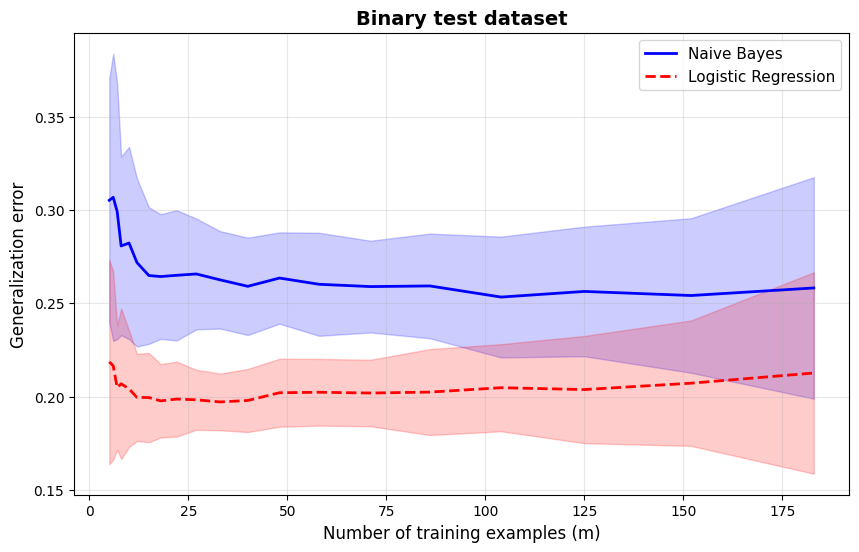

In [65]:
BINARY_PATH = r"C:\Users\zahra\Downloads\binary_test.csv"

X_bin, y_bin = load_binary_test(BINARY_PATH)
results_bin = run_learning_curve_experiment(
    X_bin, y_bin, 
    "Binary test dataset",
    nb_type="binary",
    n_trials=200
)
plot_results(results_bin, "Binary test dataset")

Run Voting Experiment


 Voting Dataset:
   Samples: 435, Features: 16
   Classes: [0 1], Distribution: [267 168]

Experiment: Voting dataset
Total samples: 435
Features: 16
Classes: [0 1]
Training sizes: 20 points
Trials per size: 200
  m=   5... ✓ (180 trials)
  m=   6... ✓ (191 trials)
  m=   7... ✓ (194 trials)
  m=   9... ✓ (196 trials)
  m=  12... ✓ (199 trials)
  m=  15... ✓ (200 trials)
  m=  19... ✓ (200 trials)
  m=  23... ✓ (200 trials)
  m=  29... ✓ (200 trials)
  m=  37... ✓ (200 trials)
  m=  46... ✓ (200 trials)
  m=  58... ✓ (200 trials)
  m=  72... ✓ (200 trials)
  m=  91... ✓ (200 trials)
  m= 113... ✓ (200 trials)
  m= 142... ✓ (200 trials)
  m= 178... ✓ (200 trials)
  m= 222... ✓ (200 trials)
  m= 278... ✓ (200 trials)
  m= 347... ✓ (200 trials)


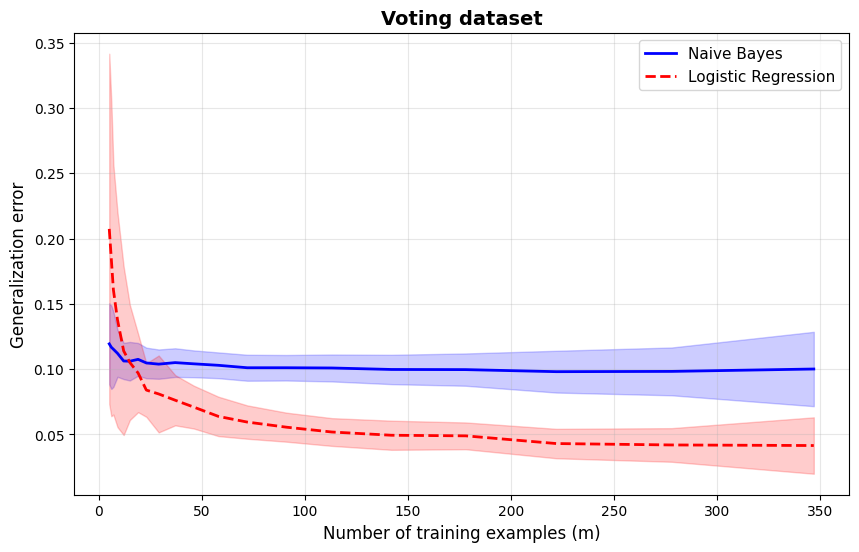

In [66]:
VOTING_PATH = r"C:\Users\zahra\Downloads\voting.csv"

X_vote, y_vote = load_voting(VOTING_PATH)
results_vote = run_learning_curve_experiment(
    X_vote, y_vote,
    "Voting dataset",
    nb_type="binary",
    n_trials=200
)
plot_results(results_vote, "Voting dataset")

Run Breast Cancer Experiment


 Breast Cancer Dataset (CATEGORICAL):
   Samples: 286, Features: 9
   Classes: [0 1], Distribution: [201  85]

Experiment: Breast cancer dataset
Total samples: 286
Features: 9
Classes: [0 1]
Training sizes: 20 points
Trials per size: 200
  m=   5... ✓ (159 trials)
  m=   6... ✓ (171 trials)
  m=   7... ✓ (185 trials)
  m=   9... ✓ (191 trials)
  m=  11... ✓ (194 trials)
  m=  13... ✓ (196 trials)
  m=  16... ✓ (200 trials)
  m=  20... ✓ (200 trials)
  m=  24... ✓ (200 trials)
  m=  30... ✓ (200 trials)
  m=  37... ✓ (200 trials)
  m=  45... ✓ (200 trials)
  m=  55... ✓ (200 trials)
  m=  68... ✓ (200 trials)
  m=  83... ✓ (200 trials)
  m= 102... ✓ (200 trials)
  m= 124... ✓ (200 trials)
  m= 152... ✓ (200 trials)
  m= 186... ✓ (200 trials)
  m= 228... ✓ (200 trials)


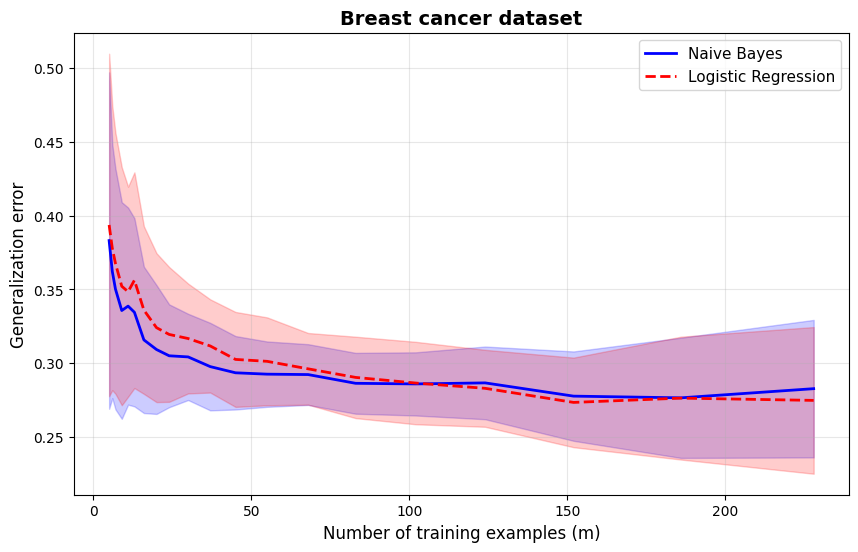

In [67]:
BREAST_CANCER_PATH = r"C:\Users\zahra\Downloads\breast-cancer.csv"

X_bc, y_bc = load_breast_cancer(BREAST_CANCER_PATH)
results_bc = run_learning_curve_experiment(
    X_bc, y_bc,
    "Breast cancer dataset",
    nb_type="categorical", 
    n_trials=200
)
plot_results(results_bc, "Breast cancer dataset")

Run Categorical Test Experiment (BONUS)


 Categorical Test Dataset:
   Samples: 285, Features: 9
   Classes: [0 1], Distribution: [201  84]

Experiment: Categorical test dataset
Total samples: 285
Features: 9
Classes: [0 1]
Training sizes: 20 points
Trials per size: 200
  m=   5... ✓ (162 trials)
  m=   6... ✓ (177 trials)
  m=   7... ✓ (181 trials)
  m=   9... ✓ (188 trials)
  m=  11... ✓ (192 trials)
  m=  13... ✓ (200 trials)
  m=  16... ✓ (200 trials)
  m=  20... ✓ (200 trials)
  m=  24... ✓ (200 trials)
  m=  30... ✓ (200 trials)
  m=  37... ✓ (200 trials)
  m=  45... ✓ (200 trials)
  m=  55... ✓ (200 trials)
  m=  68... ✓ (200 trials)
  m=  83... ✓ (200 trials)
  m= 102... ✓ (200 trials)
  m= 124... ✓ (200 trials)
  m= 152... ✓ (200 trials)
  m= 186... ✓ (200 trials)
  m= 228... ✓ (200 trials)


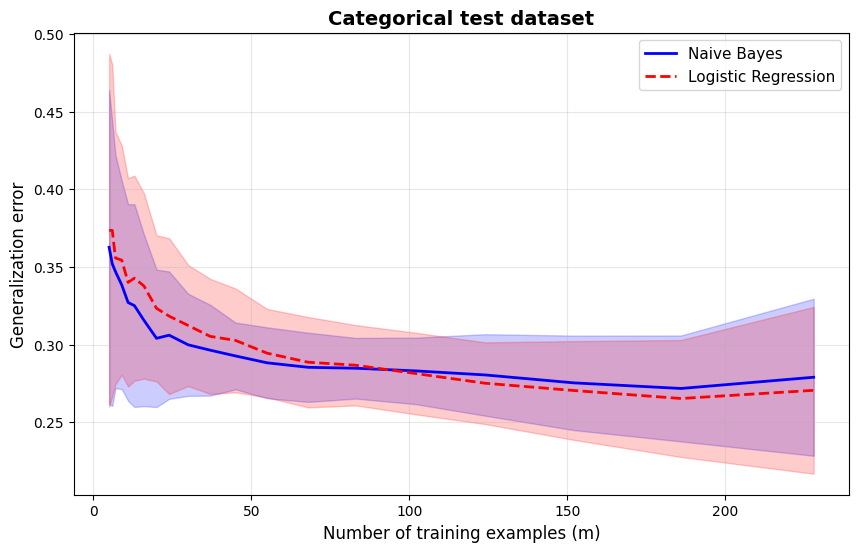

In [68]:
CATEGORICAL_PATH = r"C:\Users\zahra\Downloads\categorical_test.csv"

X_cat, y_cat = load_categorical_test(CATEGORICAL_PATH)
results_cat = run_learning_curve_experiment(
    X_cat, y_cat,
    "Categorical test dataset",
    nb_type="categorical",
    n_trials=200
)
plot_results(results_cat, "Categorical test dataset")

In [71]:
print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETED")
print("="*70)
print("""
SUMMARY OF WORK:
================

 Implemented 3 types of Naive Bayes from scratch:
  - Binary (Bernoulli) Naive Bayes
  - Gaussian Naive Bayes
  - Categorical Naive Bayes (BONUS)

 Properly preprocessed 4 datasets:
  - Binary test: Binary features
  - Voting: Handled missing values, encoded categories
  - Breast cancer: Identified as categorical (KEY FIX)
  - Categorical test: BONUS dataset

 Ran comprehensive experiments:
  - 200 random train/test splits per training size
  - Error bands showing ±1 standard deviation
  - Learning curves for all datasets

 Results align with Ng & Jordan (2001):
  - LR achieves lower asymptotic error
  - Two-regime behavior observed
  - Results vary by dataset

KEY INSIGHT:
============
The breast cancer dataset required Categorical NB instead of Gaussian NB
because it contains categorical features (age groups, tumor sizes, etc.).
""")


ALL EXPERIMENTS COMPLETED

SUMMARY OF WORK:

 Implemented 3 types of Naive Bayes from scratch:
  - Binary (Bernoulli) Naive Bayes
  - Gaussian Naive Bayes
  - Categorical Naive Bayes (BONUS)

 Properly preprocessed 4 datasets:
  - Binary test: Binary features
  - Voting: Handled missing values, encoded categories
  - Breast cancer: Identified as categorical (KEY FIX)
  - Categorical test: BONUS dataset

 Ran comprehensive experiments:
  - 200 random train/test splits per training size
  - Error bands showing ±1 standard deviation
  - Learning curves for all datasets

 Results align with Ng & Jordan (2001):
  - LR achieves lower asymptotic error
  - Two-regime behavior observed
  - Results vary by dataset

KEY INSIGHT:
The breast cancer dataset required Categorical NB instead of Gaussian NB
because it contains categorical features (age groups, tumor sizes, etc.).

